In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

sns.set()

### Using scenario 10, as requested.

In [2]:
DATA_PATH_ORIG = r'../data/capture20110818.pcap.netflow.labeled.csv'
DATA_PATH_NEW = r'../data/capture20110818.pcap.netflow.labeled_processed.csv'

## IMPORTANT     
The code below reads the file and erases the '->' characters.    
It takes quite a few minutes, so run it only if you don't have the processed file yet :(

In [3]:
# text = open(DATA_PATH_ORIG, "r")
# text = ''.join([i for i in text]) \
#     .replace("->", "")
# x = open(DATA_PATH_NEW,"w")
# x.writelines(text)
# x.close()

Read the data

In [4]:
column_names = ['_', '_2', 'duration', 'protocol', 'src_addr', 'dst_addr', 'flags', 'tos', 'packets', 'bytes', 'flows', 'label']

df = pd.read_csv(
    DATA_PATH_NEW,
    delimiter='\s+',
    skiprows=[0],
    header=None, 
    names=column_names,
    index_col=False,
    parse_dates={"start_date": [0,1]}
)
df = df.sort_values('start_date')
df.head()

,start_date,duration,protocol,src_addr,dst_addr,flags,tos,packets,bytes,flows,label
0,2011-08-18 10:19:13.328,0.002,TCP,147.32.86.166:33426,212.24.150.110:25443,FRPA_,0,4,321,1,Background
1,2011-08-18 10:19:13.328,4.995,UDP,82.39.2.249:41915,147.32.84.59:43087,INT,0,617,40095,1,Background
2,2011-08-18 10:19:13.329,4.996,UDP,147.32.84.59:43087,82.39.2.249:41915,INT,0,1290,1909200,1,Background
3,2011-08-18 10:19:13.330,0.000,TCP,147.32.86.166:42020,147.32.192.34:993,A_,0,1,66,1,Background
4,2011-08-18 10:19:13.330,0.000,TCP,212.24.150.110:25443,147.32.86.166:33426,FPA_,0,2,169,1,Background


Have a look at the labels we have

In [5]:
df['label'].unique()

array(['Background', 'LEGITIMATE', 'Botnet'], dtype=object)

Remove all background flows from the data

In [6]:
df_no_back = df[df['label'] != 'Background']

We need to select one infected host and investigate the data. We select '147.32.84.165' by looking at the documentation of scenario 10.

In [7]:
infected_host_ip = '147.32.84.165'
inf_data = df_no_back[(df_no_back['src_addr'] == infected_host_ip) | (df_no_back['dst_addr'] == infected_host_ip)]
inf_data.reset_index(drop=True, inplace=True)
print(f"{inf_data.shape[0]} connections with infected host '{infected_host_ip}' found.")

28343 connections with infected host '147.32.84.165' found.


## Data investigation to find two features to use

In [8]:
inf_data.label.unique()

array(['Botnet'], dtype=object)

In [9]:
inf_data.protocol.unique()

array(['ICMP'], dtype=object)

Only botnet!

In [10]:
inf_data.describe()

,duration,tos,packets,bytes,flows
count,28343.000000,28343.0,28343.000000,28343.000000,28343.0
mean,0.573841,0.0,3.824966,4077.342342,1.0
std,1.427250,0.0,11.342433,12091.051018,0.0
min,0.000000,0.0,1.000000,120.000000,1.0
25%,0.000000,0.0,1.000000,1066.000000,1.0
50%,0.000000,0.0,1.000000,1066.000000,1.0
75%,0.000000,0.0,1.000000,1066.000000,1.0
max,4.999000,0.0,144.000000,153504.000000,1.0


Let's have a look at duration and bytes.

In [11]:
inf_data['delta'] = (inf_data['start_date']-inf_data['start_date'].shift()).fillna(0).values.astype(np.int64) // 10 ** 6
inf_data.head(5)

C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  """Entry point for launching an IPython kernel.
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,start_date,duration,protocol,src_addr,dst_addr,flags,tos,packets,bytes,flows,label,delta
0,2011-08-18 12:18:30.808,4.953,ICMP,147.32.96.69,147.32.84.165,MSR,0,95,101270,1,Botnet,0
1,2011-08-18 12:18:30.811,0.000,ICMP,147.32.96.69,147.32.84.165,ECR,0,1,1066,1,Botnet,3
2,2011-08-18 12:18:30.812,4.991,ICMP,147.32.96.69,147.32.84.165,TSR,0,85,90610,1,Botnet,1
3,2011-08-18 12:18:30.813,2.229,ICMP,147.32.96.69,147.32.84.165,ECR,0,2,2132,1,Botnet,1
4,2011-08-18 12:18:30.815,0.000,ICMP,147.32.84.165,147.32.96.69,UNK,0,1,1066,1,Botnet,2


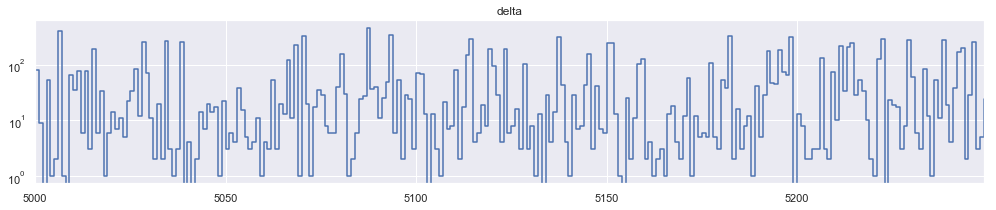

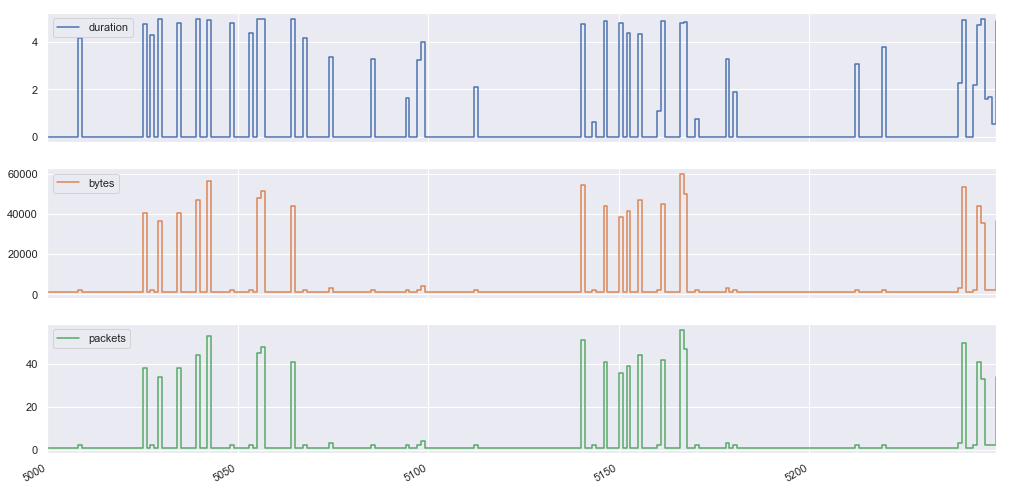

In [12]:
inf_data['delta'].iloc[5000:5250].plot(figsize=(17,3*1), drawstyle='steps-post')
plt.yscale("log")
plt.title("delta")
plt.show()

inf_data[['duration', 'bytes', 'packets']].iloc[5000:5250].plot(figsize=(17,3*3), subplots=True, drawstyle='steps-post')
plt.show()

### Selected features: duration, bytes, delta

In [13]:
feat_df = inf_data[['duration', 'bytes', 'delta', 'packets']]

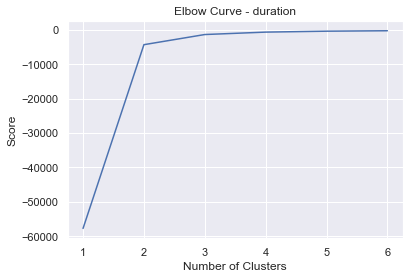

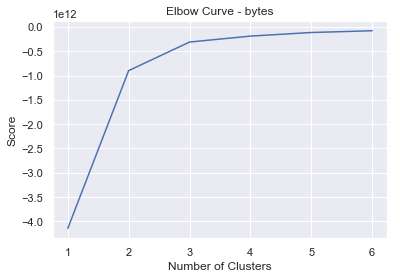

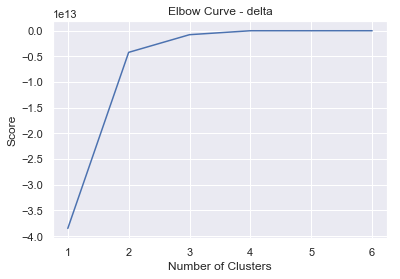

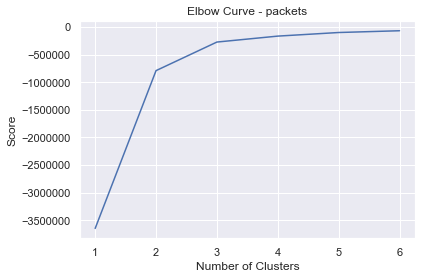

In [14]:
for feat in feat_df.columns:
    Nc = range(1, 7)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    data = feat_df[feat].values.reshape(-1, 1)
    score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]
    plt.plot(Nc,score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title(f'Elbow Curve - {feat}')
    plt.show()

By looking at the ELBOW plots, we find the optimal number of cluster for each numerical feature

In [15]:
clust_values = {
    'duration': [50],
    'bytes': [33, 85],
    'delta': [33, 66],
    'packets': [33, 85]
}

In [16]:
def get_indices(percentiles,values):
    breaks = []
    for p in percentiles:
        breaks.append(np.percentile(values,p))
    return breaks

def mapping(values, percentiles):    
    breakpoints = get_indices(percentiles, values)
    new_values = []
    for value in values:
        for index, breakpoint in enumerate(breakpoints):
            if breakpoint >= value:
                new_values.append(index)
                break
        else:
            new_values.append(len(breakpoints))
    return new_values

Testing

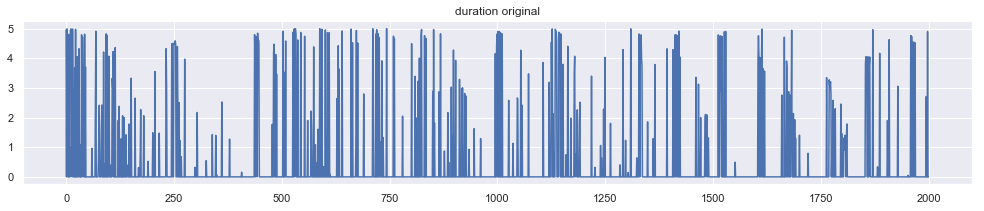

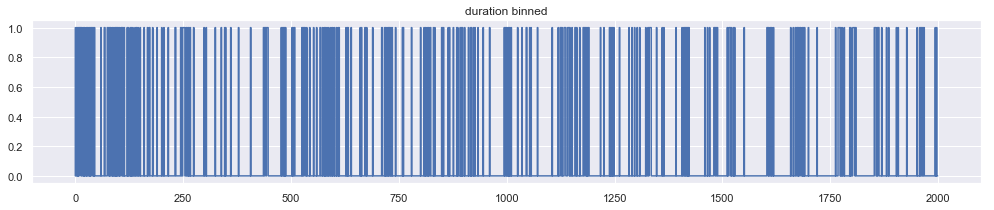

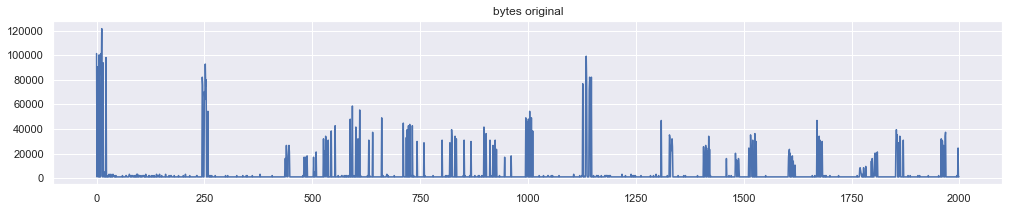

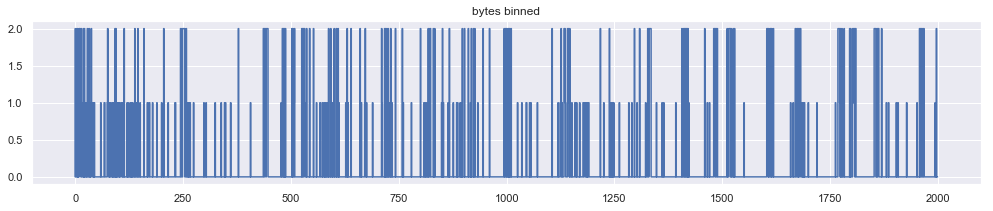

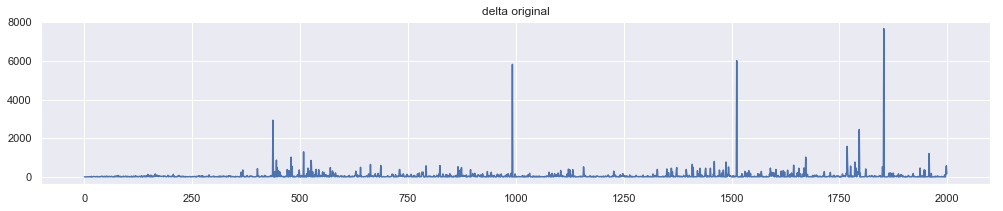

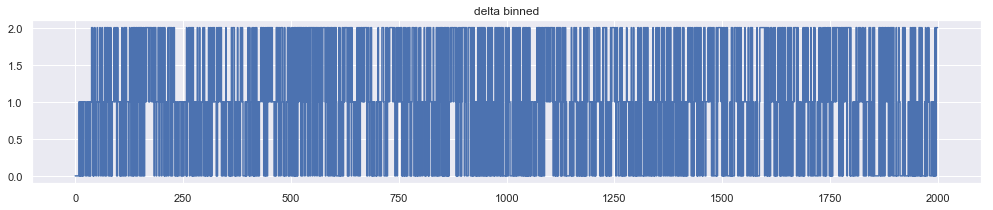

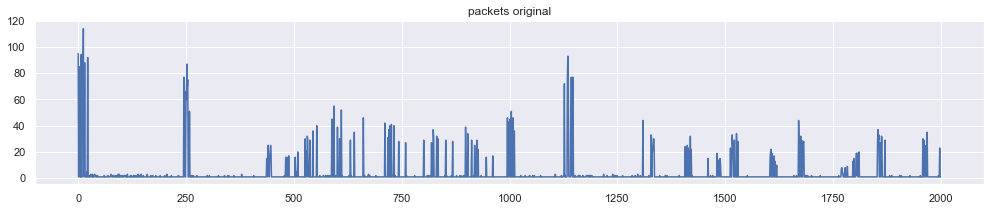

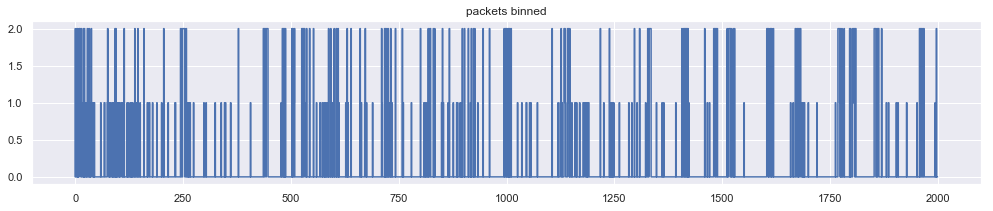

In [25]:
for feat in feat_df.columns:
    values = feat_df[feat].values
    new_values = mapping(values, clust_values[feat])

    plt.figure(figsize=(17,3))
    plt.plot(values[0:2000])
    #plt.yscale("log")
    plt.title(f"{feat} original")
    plt.show()

    plt.figure(figsize=(17,3))
    plt.plot(new_values[0:2000], drawstyle='steps')
    plt.title(f"{feat} binned")
    plt.show()

Let's create the data with the two chosen features: duration and packets

In [42]:
df = pd.DataFrame(
    {
        'duration': mapping(inf_data['duration'], clust_values['duration']),
        'packets': mapping(inf_data['packets'], clust_values['packets']),
    }
)
df.head()

,duration,packets
0,1,2
1,0,0
2,1,2
3,1,1
4,0,0


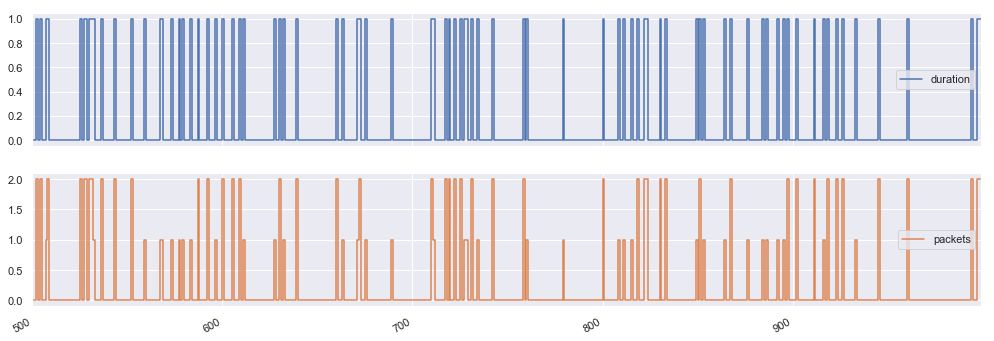

In [49]:
df.iloc[500:1000].plot(figsize=(17, 6), subplots=True, drawstyle='steps')
plt.show()

In [52]:
from functools import reduce
def get_code(data_df):
    uniques = {col:df[col].nunique() for col in df.columns}
    num_of_elems_per_feat = [uniques[name] for name in uniques]
    codes = []
    for idx, row in data_df.iterrows():
        code = 0
        space_size = reduce(lambda x,y: x*y, num_of_elems_per_feat, 1)
        
        for col in data_df.columns:
            code += row[col] * space_size / uniques[col]
            space_size /= uniques[col]
        codes.append(code)
    
    return pd.Series(codes)

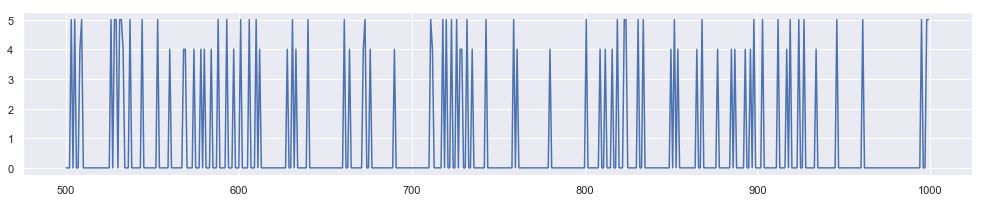

In [54]:
coded_df = get_code(df)
plt.figure(figsize=(17, 3))
plt.plot(coded_df[500:1000])
plt.show()

# Compute for every host